In [1]:
# mount GDrive
from google.colab import drive
drive.mount('/content/drive')
#drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
# load dataset
!cp "drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/lyrics_dataset.json.gz" .

# load sexism classifications
!cp -r "drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10_no_duplicates/Results_sexism_detection" .

In [3]:
%pylab inline 
import pandas as pd
import glob
from collections import defaultdict
from scipy import stats, signal
#from statsmodels.stats.contingency_tables import Table2x2
import statsmodels.api as sm

rng = np.random.RandomState(42)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def get_artist_gender_and_type(author_info):

    artist_type = author_info['type']

    if artist_type=='Person':
        artist_gender = author_info['gender']
        n_males, n_females = None, None
    else:
        n_males, n_females = author_info['n_male'], author_info['n_female']
        if n_males==author_info['n_members']:
            artist_gender = 'Male'
        elif n_females==author_info['n_members']:
            artist_gender = 'Female'
        elif n_males*n_females!=0 and n_females+n_males==author_info['n_members']:
            artist_gender = 'Mix'
        else:
            print('Problem with group gender assignation..')

    return artist_gender, artist_type, n_males, n_females

In [5]:
def filter_signal(arr, w=5):
    ''' Filters the signal in arr (1D array). Returns an array with the same dim of arr
    '''
    return signal.medfilt(arr, kernel_size=w)

def plot_line_with_smoothing(X, Y, label, color):

    raw_lines = plt.plot(X, Y, alpha=0.5, ls='dashed', color=color)
    plt.plot(X,
            filter_signal(Y, w=5),
            color=raw_lines[0].get_color(), 
             label=label,
             )

In [6]:
# define colors
categ2color = {
    'Person - Male':'#377eb8',
    'Person - Female':'#ff7f00',
    'Group - Male':'#4daf4a',
    'Group - Female':'#984ea3',
    'Group - Mix':'#e41a1c'
}


### Load and combine data 

In [7]:
# load main dataset
song_lyrics = pd.read_json("lyrics_dataset.json.gz", orient='records', lines=True)
song_lyrics = song_lyrics.drop(columns=['lyrics'])

print("Number of song lyrics: ", song_lyrics.shape[0])

Number of song lyrics:  377808


In [8]:
# load sexism classifications
# we ran the classifier on unique lyrics (without duplicates and covers)
sexism_files = glob.glob("Results_sexism_detection/*.json")

lyrics_sexism = []
for file in sexism_files:
    data_chunk = pd.read_json(file, orient='records', lines=True, chunksize=5000 )
    for chunk in data_chunk:   
        chunk = chunk[['song_id', 'sexist_lines']]
        lyrics_sexism.append(chunk)

lyrics_sexism = pd.concat(lyrics_sexism)
lyrics_sexism.loc[:, 'is_sexist'] = lyrics_sexism.sexist_lines.apply(lambda sl: any([p[0]>=0.725 for p in sl]))

In [9]:
# merge with main dataset
# covers have not the sexism label, we need to propagate it
song_lyrics = song_lyrics.merge(lyrics_sexism, on='song_id', how='left')

# propagate sexism label to song covers
# this df used to get covered songs
cover_songs_is_sexist = song_lyrics[(song_lyrics.song_id.isin(song_lyrics.cover_of.unique()))][['song_id', 'cover_of', 'is_sexist']]
cover_songs_is_sexist = cover_songs_is_sexist.set_index('song_id')

song_lyrics.loc[:, 'is_sexist'] = song_lyrics.apply(lambda row: 
            row.is_sexist if not pd.isna(row.is_sexist) else cover_songs_is_sexist.loc[row.cover_of].is_sexist,
            axis=1)

print('Number of songs: ', song_lyrics.shape[0])

Number of songs:  377808


In [10]:
# extract info about artist gender and type
song_lyrics['artist_gender'], song_lyrics['artist_type'], song_lyrics['n_males'], song_lyrics['n_females'] =  \
                        zip(*song_lyrics.other_artist_info.apply(get_artist_gender_and_type))

song_lyrics.head()

song_id          song_title  ... n_males n_females
0  5714dec325ac0d8aee3863ff  Long Live The King  ...     NaN       NaN
1  5714dec325ac0d8aee386400     The Last Supper  ...     NaN       NaN
2  5714dec325ac0d8aee386401          Gethsemane  ...     NaN       NaN
3  5714dec325ac0d8aee386402            Betrayal  ...     NaN       NaN
4  5714dec325ac0d8aee386403    Son Of The World  ...     NaN       NaN

[5 rows x 25 columns]

In [11]:
song_lyrics = song_lyrics.reset_index(drop=True)
song_lyrics.shape[0]

377808

In [12]:
# number of years
song_lyrics.song_year_combined.nunique()

50

### Split into 3 datasets: WASABI, Billboard, and BillboardTop10

In [13]:
# define lambda functions to return quickly subsets of data
is_topn = lambda chart_ranks, n: any([r<=n for r in chart_ranks]) if type(chart_ranks)==list else False
is_top10 = lambda chart_ranks: is_topn(chart_ranks, 10)

In [14]:
# make the billboard and billboard top10 datasets
song_lyrics_billboard = song_lyrics[song_lyrics.is_billboard]
song_lyrics_billboard_top10 = song_lyrics[(song_lyrics.is_billboard)&
                                          (song_lyrics.chart_positions.apply(is_top10))]

print('Number of songs in Billboard: ', song_lyrics_billboard.shape[0])
print('Number of songs in Billboard top10: ', song_lyrics_billboard_top10.shape[0])

Number of songs in Billboard:  10798
Number of songs in Billboard top10:  2608


### Basic statistics genres


In [15]:
all_genres = set()
for genres in song_lyrics.genre_combined_reduced.dropna().values:
    all_genres.update(genres)
all_genres

{'African',
 'Avant-garde',
 'Blues',
 'Caribbean and Caribbean-influenced',
 'Comedy',
 'Country',
 'Easy listening',
 'Electronic',
 'Folk',
 'Hip hop',
 'Jazz',
 'Latin',
 'Pop',
 'R&B and soul',
 'Rock',
 'South and southeast Asian'}

In [16]:
# fraction of lyrics with missing genre
song_lyrics.genre_combined_reduced.isna().value_counts()

False    331326
True      46482
Name: genre_combined_reduced, dtype: int64

In [17]:
# fraction of lyrics with missing genre
song_lyrics.genre_combined_reduced.isna().value_counts(1)

False    0.876969
True     0.123031
Name: genre_combined_reduced, dtype: float64

In [18]:
# fraction of lyrics with missing genre
song_lyrics_billboard.genre_combined_reduced.isna().value_counts()

False    10416
True       382
Name: genre_combined_reduced, dtype: int64

In [19]:
# fraction of lyrics with missing genre
song_lyrics_billboard.genre_combined_reduced.isna().value_counts(1)

False    0.964623
True     0.035377
Name: genre_combined_reduced, dtype: float64

In [20]:
# fraction of lyrics with missing genre
song_lyrics_billboard_top10.genre_combined_reduced.isna().value_counts()

False    2543
True       65
Name: genre_combined_reduced, dtype: int64

In [21]:
# fraction of lyrics with missing genre
song_lyrics_billboard_top10.genre_combined_reduced.isna().value_counts(1)

False    0.975077
True     0.024923
Name: genre_combined_reduced, dtype: float64

In [22]:
# Replace all songs with missing genre with an empty list
song_lyrics.loc[:, 'genre_combined_reduced'] = song_lyrics.genre_combined_reduced.apply(lambda gs: [] if type(gs) is not list else gs)
song_lyrics_billboard.loc[:, 'genre_combined_reduced'] = song_lyrics_billboard.genre_combined_reduced.apply(lambda gs: [] if type(gs) is not list else gs)
song_lyrics_billboard_top10.loc[:, 'genre_combined_reduced'] = song_lyrics_billboard_top10.genre_combined_reduced.apply(lambda gs: [] if type(gs) is not list else gs)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [23]:
# for each genre, count how many songs have this genre in the genres list
# NOTE: the sum of all fractions is not 1 because songs can have more than 1 genre
n_songs_for_genre = {}

n_songs_with_genre = song_lyrics.genre_combined_reduced.dropna().shape[0]
for genre in all_genres:
    n_genre = song_lyrics.genre_combined_reduced.apply(lambda gs: genre in gs).sum()

    n_songs_for_genre[genre] = n_genre

n_songs_for_genre = pd.DataFrame.from_dict(n_songs_for_genre, orient='index')
n_songs_for_genre.columns = ['n_songs']
n_songs_for_genre.index.name = 'genre'

n_songs_for_genre.loc[:, 'frac_songs'] = n_songs_for_genre.n_songs / n_songs_with_genre
n_songs_for_genre = n_songs_for_genre.sort_values('n_songs', ascending=False)
n_songs_for_genre.head()

n_songs  frac_songs
genre                            
Rock           157202    0.416090
Pop             67057    0.177490
Country         50055    0.132488
Hip hop         33400    0.088405
R&B and soul    32693    0.086533

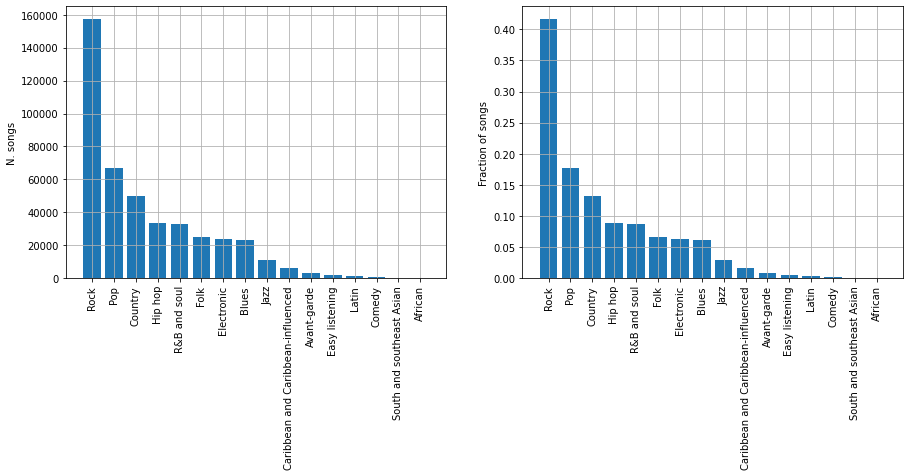

In [24]:
# show distribution of genres
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(range(len(all_genres)), n_songs_for_genre.n_songs)
plt.xticks(range(n_songs_for_genre.shape[0]), n_songs_for_genre.index, rotation=90);
plt.ylabel('N. songs')
plt.grid()

plt.subplot(1,2,2)
plt.bar(range(len(all_genres)), n_songs_for_genre.frac_songs)
plt.xticks(range(n_songs_for_genre.shape[0]), n_songs_for_genre.index, rotation=90);
plt.ylabel('Fraction of songs')
plt.grid();

In [25]:
genres_of_interest = ['Pop', 'Rock', 'Hip hop', 'R&B and soul']

Skipped genres:  Caribbean and Caribbean-influenced, Avant-garde, Easy listening, Latin, Comedy, South and southeast Asian, African


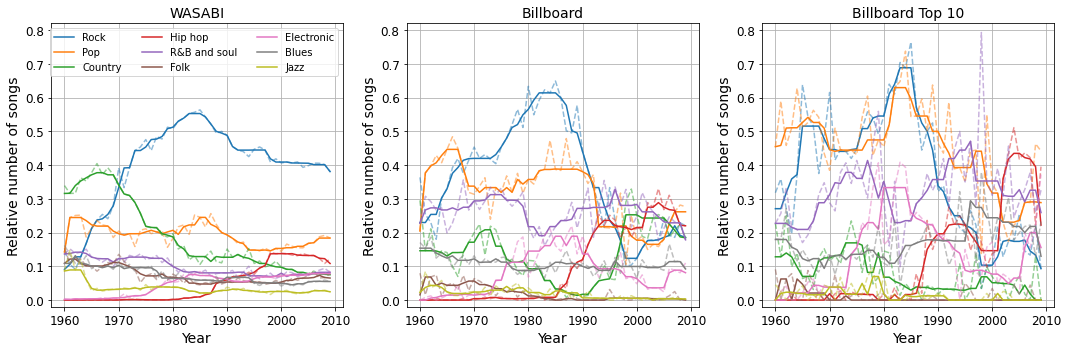

In [26]:
# for each dataset, plot relative number of songs for each genre
plt.figure(figsize=(15,5))

genres_to_skip = []
for ii, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard, song_lyrics_billboard_top10],
                                           ['WASABI', 'Billboard', 'Billboard Top 10']),
                                       1):
    
    plt.subplot(1,3,ii)
    for genre in n_songs_for_genre.index:

        frac_songs_genre = df.groupby("song_year_combined").apply(lambda rows: 
                                                                  rows[rows.genre_combined_reduced.apply(lambda gs: genre in gs)].shape[0]/rows.shape[0] ).sort_index()

        # if no bin with relative frction higher than 5% in WASABI, skip the genre always
        if df_name=='WASABI':
            if not (frac_songs_genre>0.05).any(): 
                    genres_to_skip.append(genre)
                    continue
        else:
            if genre in genres_to_skip:
                continue

        plot_line_with_smoothing(frac_songs_genre.index, 
                                 frac_songs_genre.values,
                                 label=genre, color=None)
        
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Relative number of songs', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.title(df_name, fontsize=14)
    plt.grid()
    if df_name=='WASABI':
        plt.legend(ncol=3)
    plt.title(df_name, fontsize=14)
    plt.ylim(-0.02, 0.82)

plt.tight_layout()

print("Skipped genres: ", ", ".join(genres_to_skip))

Skipped genres:  Caribbean and Caribbean-influenced, Avant-garde, Easy listening, Latin, Comedy, South and southeast Asian, African


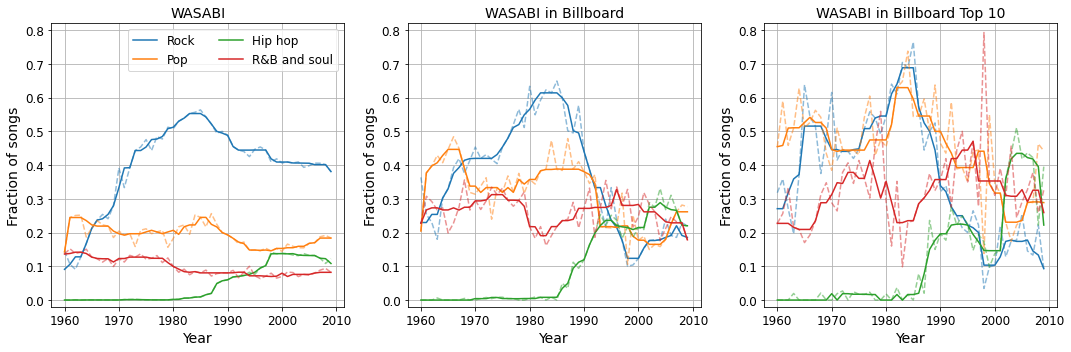

In [27]:
# for each dataset, plot relative number of songs for each genre (only genres of interest)
fig = plt.figure(figsize=(15,5))

#genres_to_skip = []
for ii, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard, song_lyrics_billboard_top10],
                                           ['WASABI', 'WASABI in Billboard', 'WASABI in Billboard Top 10']),
                                       1):
    
    plt.subplot(1,3,ii)
    for genre in n_songs_for_genre.index:
        if genre not in genres_of_interest: continue

        frac_songs_genre = df.groupby("song_year_combined").apply(lambda rows: 
                                                                  rows[rows.genre_combined_reduced.apply(lambda gs: genre in gs)].shape[0]/rows.shape[0] ).sort_index()

        # if no bin with relative frction higher than 5% in WASABI, skip the genre always
        if df_name=='WASABI':
            if not (frac_songs_genre>0.05).any(): 
                    genres_to_skip.append(genre)
                    continue
        else:
            if genre in genres_to_skip:
                continue

        plot_line_with_smoothing(frac_songs_genre.index, 
                                 frac_songs_genre.values,
                                 label=genre, color=None)
        
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Fraction of songs', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.title(df_name, fontsize=14)
    plt.grid()
    if df_name=='WASABI':
        plt.legend(ncol=2, fontsize=12)
    plt.title(df_name, fontsize=14)
    plt.ylim(-0.02, 0.82)

plt.tight_layout()

print("Skipped genres: ", ", ".join(genres_to_skip))

fig.savefig("frac_songs_wasabi_and_billboard_genre.pdf", dpi=500, format='pdf') 

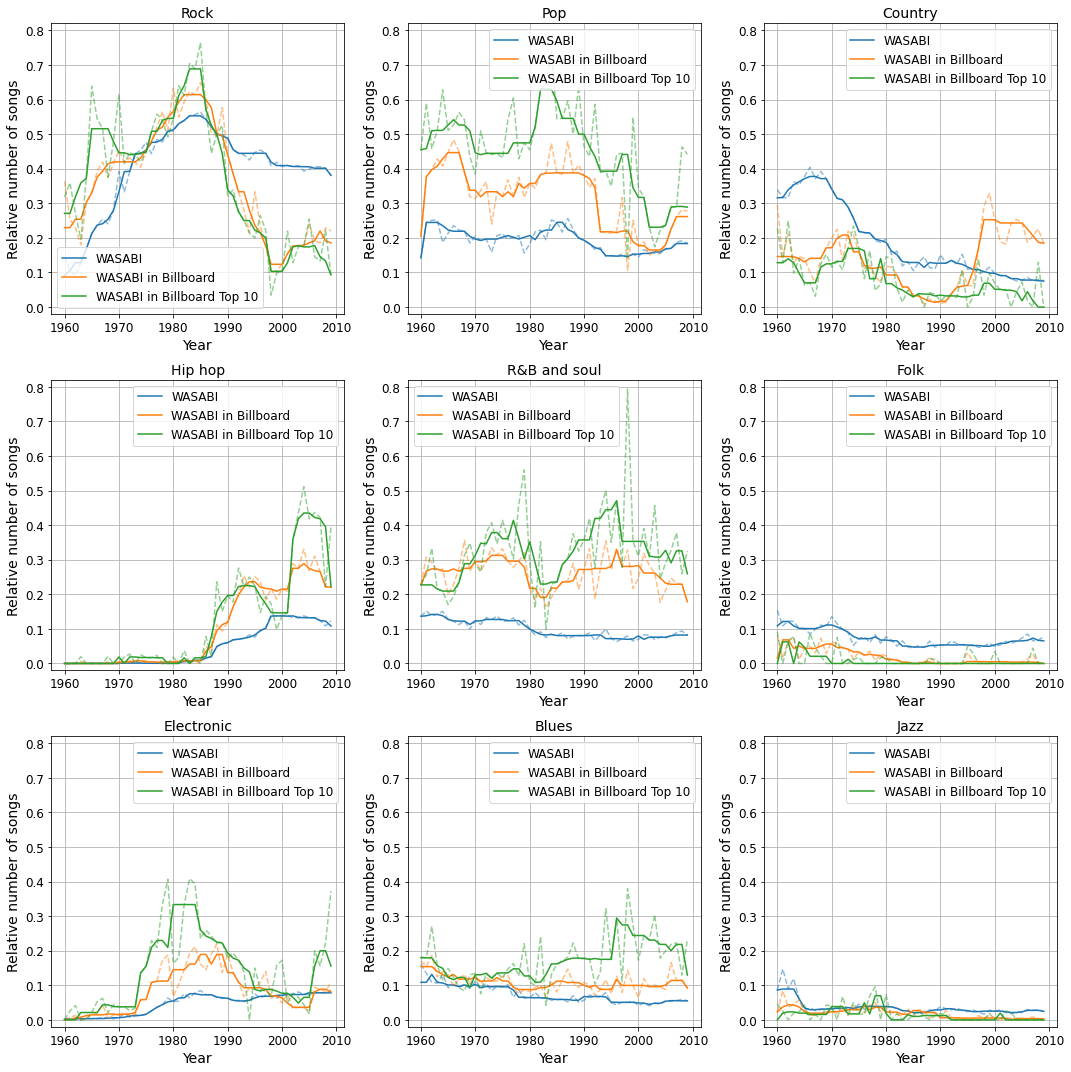

In [28]:
# for each genre, plot the relative fraction of songs for each dataset
plt.figure(figsize=(15,15))
n_plots_shown = 0
n_plots = len(n_songs_for_genre.index) - len(genres_to_skip)

n_cols = 3
n_rows = np.ceil(n_plots // n_cols)

for ii, genre in enumerate(n_songs_for_genre.index, 1):
    if genre in genres_to_skip:
        continue

    plt.subplot(n_rows,n_cols,n_plots_shown+1)
    for jj, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard, song_lyrics_billboard_top10],
                                           ['WASABI', 'WASABI in Billboard', 'WASABI in Billboard Top 10']),
                                       1):

        frac_songs_genre = df.groupby("song_year_combined").apply(lambda rows: 
                                                                  rows[rows.genre_combined_reduced.apply(lambda gs: genre in gs)].shape[0]/rows.shape[0] ).sort_index()

        
        plot_line_with_smoothing(frac_songs_genre.index, 
                                 frac_songs_genre.values,
                                 label=df_name, color=None)
        
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Relative number of songs', fontsize=14)
    plt.tick_params(labelsize=12)
    plt.title(genre, fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)
    plt.ylim(-0.02, 0.82)
    n_plots_shown += 1

plt.tight_layout()

### Fraction of female lyrics across time

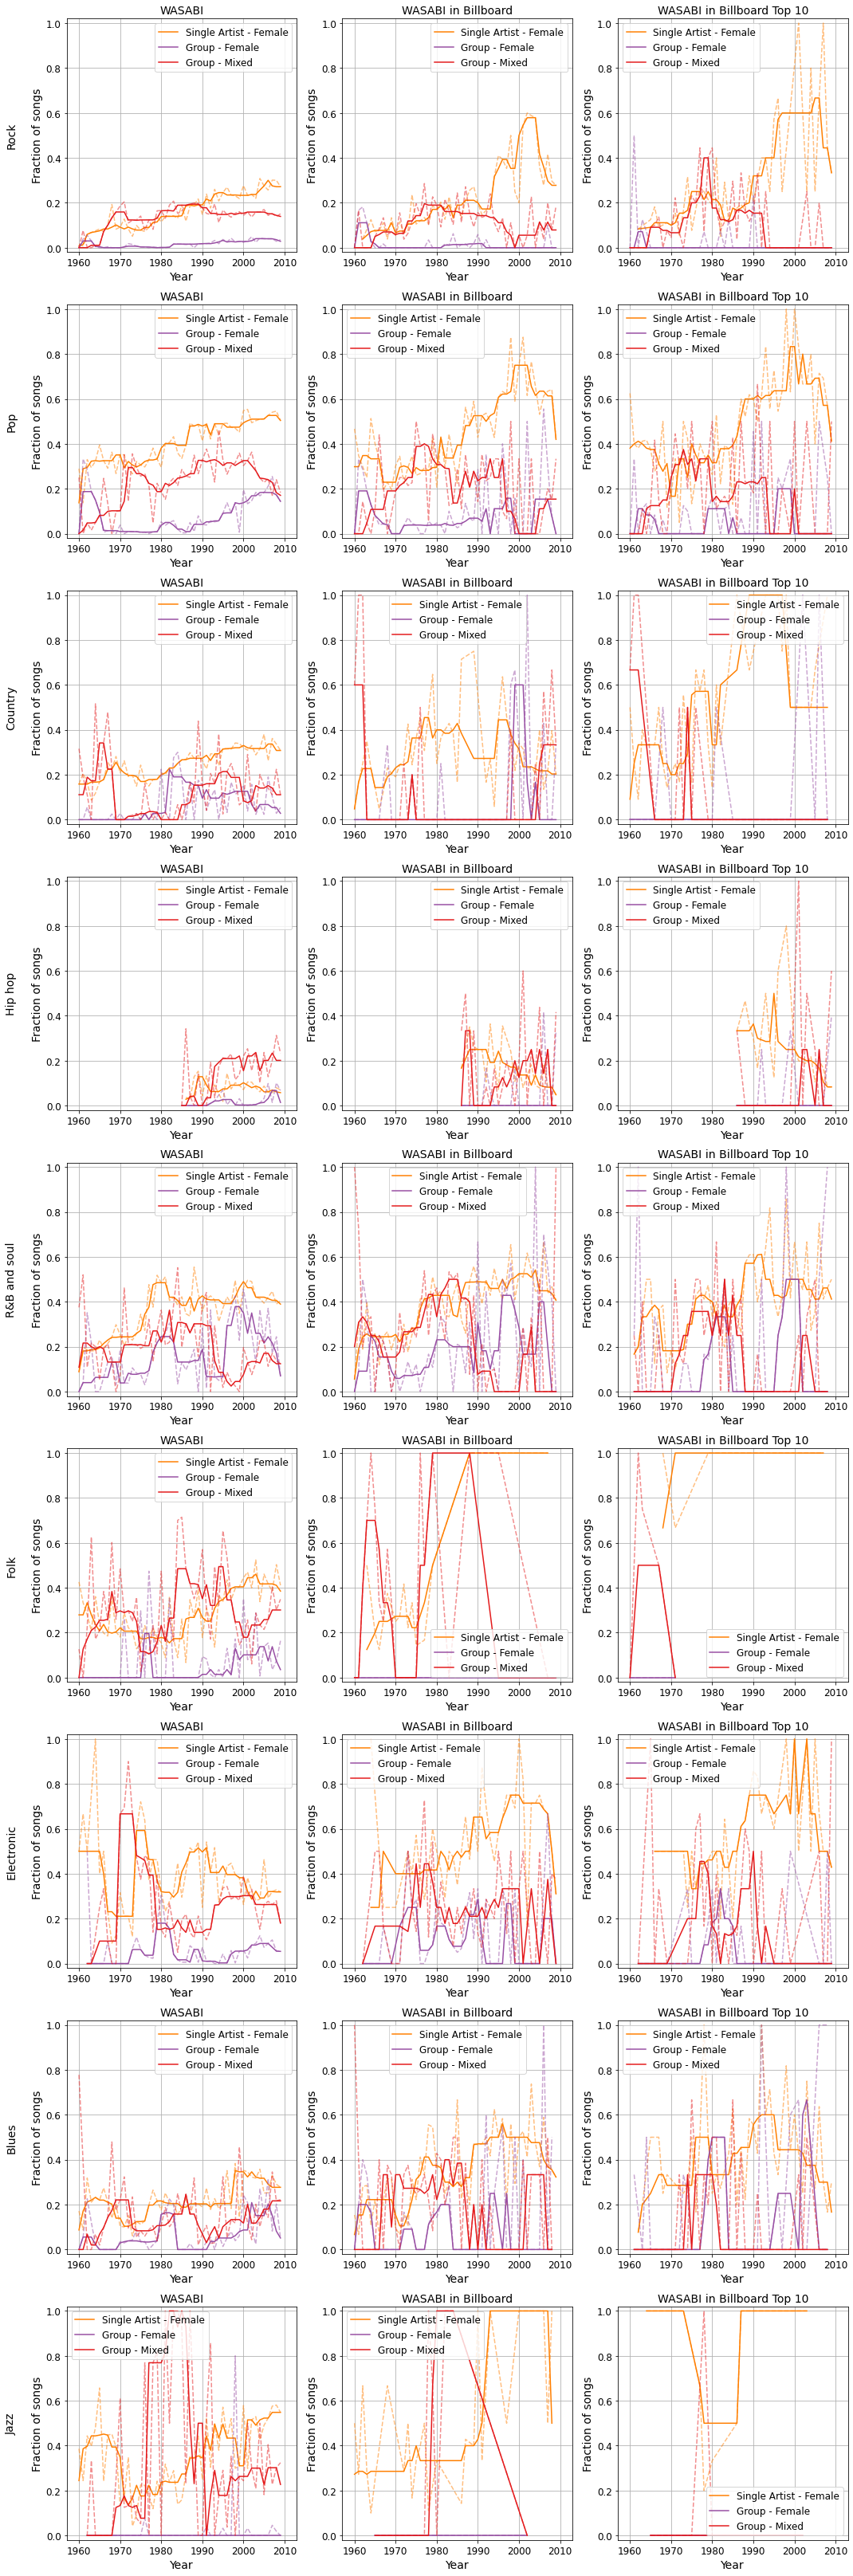

In [29]:
n_plots_shown = 0
n_plots = (len(n_songs_for_genre.index) - len(genres_to_skip)) * 3

n_cols = 3
n_rows = np.ceil(n_plots // n_cols)

plt.figure(figsize=(15,5*n_rows))


for ii, genre in enumerate(n_songs_for_genre.index, 0):
    if genre in genres_to_skip:
        continue

    for jj, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard, song_lyrics_billboard_top10],
                                           ['WASABI', 'WASABI in Billboard', 'WASABI in Billboard Top 10']),
                                       1):
        
        if genre=='Hip hop':
            df = df[df.song_year_combined>=1985]

        plt.subplot(n_rows, n_cols, 3*ii+jj)
        frac_females_person = df[(df.artist_type=='Person')&
                                 (df.genre_combined_reduced.apply(lambda gs: genre in gs))].groupby('song_year_combined')['artist_gender']\
                                .value_counts(1).loc[:, 'Female']\
                                .sort_index()
        frac_group = df[(df.artist_type=='Group')&
                                 (df.genre_combined_reduced.apply(lambda gs: genre in gs))].groupby('song_year_combined')['artist_gender']\
                                    .value_counts(1)
        levels = [frac_group.index.levels[0], ['Male', 'Female', 'Mix']]
        new_index = pd.MultiIndex.from_product(levels, names=frac_group.index.names)
        frac_group = frac_group.reindex(new_index, fill_value=0)

        frac_group_female = frac_group.loc[:, 'Female'].sort_index()
        frac_mix_group = frac_group.loc[:, 'Mix'].sort_index()


        plot_line_with_smoothing(frac_females_person.index, frac_females_person.values, label='Single Artist - Female',
                                 color=categ2color['Person - Female'])
        plot_line_with_smoothing(frac_group_female.index, frac_group_female.values, label='Group - Female',
                                 color=categ2color['Group - Female'])
        plot_line_with_smoothing(frac_mix_group.index, frac_mix_group.values, label='Group - Mixed',
                                 color=categ2color['Group - Mix'])
        
        plt.xlabel('Year', fontsize=14)
        if jj==1:
            plt.ylabel(f'{genre}\n\nFraction of songs', fontsize=14)
        else:
            plt.ylabel(f'Fraction of songs', fontsize=14)
        plt.tick_params(labelsize=12)
        plt.title(df_name, fontsize=14)
        plt.grid()
        plt.legend(fontsize=12)
        plt.ylim(-0.02, 1.02)
        plt.xlim(1957, 2013)
        n_plots_shown += 1

plt.tight_layout()
    

### Sexist lyrics across time and artist gender/type

In [35]:
def get_line_with_median_smoothing(df, window=5, alpha=0.05, iters=1000, random_state=None):

    half_window = window // 2
    line = []
    for year in df.song_year_combined.sort_values().unique():

        df_ = df[(df.song_year_combined>=year-2)&
                 (df.song_year_combined<=year+2)]

        frac_sexist = df_.groupby('song_year_combined')['is_sexist'].value_counts(1)
        levels = [frac_sexist.index.levels[0], [True, False]]
        new_index = pd.MultiIndex.from_product(levels, names=frac_sexist.index.names)
        frac_sexist = frac_sexist.reindex(new_index, fill_value=0)
        frac_sexist = frac_sexist.loc[:, True].median()

        fracs_sexist_boot = []
        for _ in range(iters):
            df_boot = df_.sample(frac=1., replace=True, random_state=random_state)
            frac_sexist_boot = df_boot.groupby('song_year_combined')['is_sexist'].value_counts(1)
            levels = [frac_sexist_boot.index.levels[0], [True, False]]
            new_index = pd.MultiIndex.from_product(levels, names=frac_sexist_boot.index.names)
            frac_sexist_boot = frac_sexist_boot.reindex(new_index, fill_value=0)
            frac_sexist_boot = frac_sexist_boot.loc[:, True].median()
            fracs_sexist_boot.append(frac_sexist_boot)
        fracs_sexist_boot = np.array(fracs_sexist_boot)

        #CI_l = 2*frac_sexist - np.quantile(fracs_sexist_boot, q=1-alpha/2)
        #CI_u = 2*frac_sexist - np.quantile(fracs_sexist_boot, q=alpha/2)
        CI_l = np.quantile(fracs_sexist_boot, q=alpha/2)
        CI_u = np.quantile(fracs_sexist_boot, q=1-alpha/2)

        line.append([year, frac_sexist, CI_l, CI_u])

    return np.array(line)

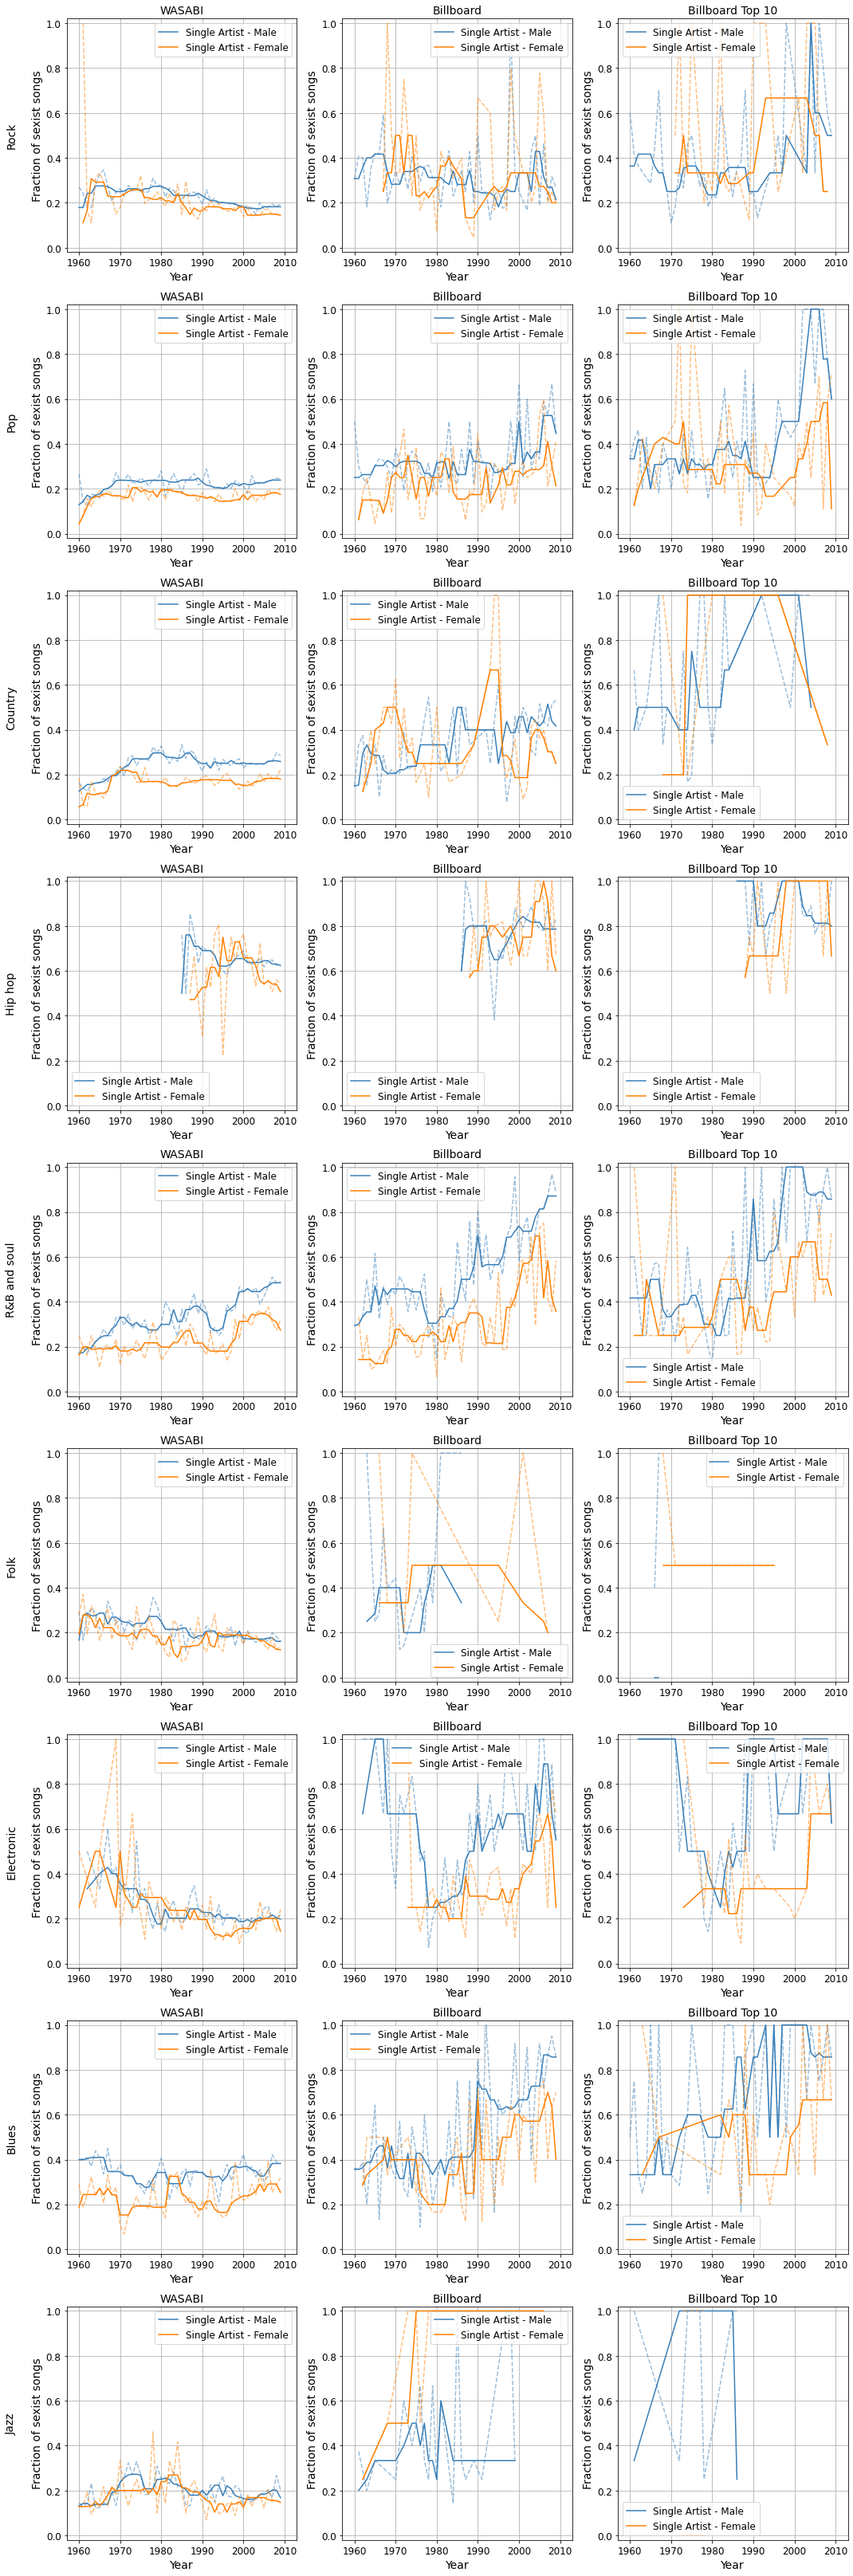

In [31]:
n_plots_shown = 0
n_plots = (len(n_songs_for_genre.index) - len(genres_to_skip)) * 3

n_cols = 3
n_rows = np.ceil(n_plots // n_cols)

plt.figure(figsize=(15,5*n_rows))


for ii, genre in enumerate(n_songs_for_genre.index, 0):
    if genre in genres_to_skip:
        continue

    for jj, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard, song_lyrics_billboard_top10],
                                           ['WASABI', 'Billboard', 'Billboard Top 10']),
                                       1):
        
        if genre=='Hip hop':
            df = df[df.song_year_combined>=1985]

        plt.subplot(n_rows, n_cols, 3*ii+jj)
        for gender in ['Male', 'Female']:
            frac_type_gender = df[(df.artist_type=='Person')&
                                  (df.genre_combined_reduced.apply(lambda gs: genre in gs))&
                                (df.artist_gender==gender)].groupby('song_year_combined')['is_sexist']\
                                        .value_counts(1).loc[:, True].sort_index()
            plot_line_with_smoothing(frac_type_gender.index, frac_type_gender.values, 
                                     label=f'Single Artist - {gender}', color=categ2color[f'Person - {gender}'])
        
        plt.xlabel('Year', fontsize=14)
        if jj==1:
            plt.ylabel(f'{genre}\n\nFraction of sexist songs', fontsize=14)
        else:
            plt.ylabel(f'Fraction of sexist songs', fontsize=14)
        plt.tick_params(labelsize=12)
        plt.title(df_name, fontsize=14)
        plt.grid()
        plt.legend(fontsize=12)
        plt.ylim(-0.02, 1.02)
        plt.xlim(1957, 2013)
        n_plots_shown += 1

plt.tight_layout()
    

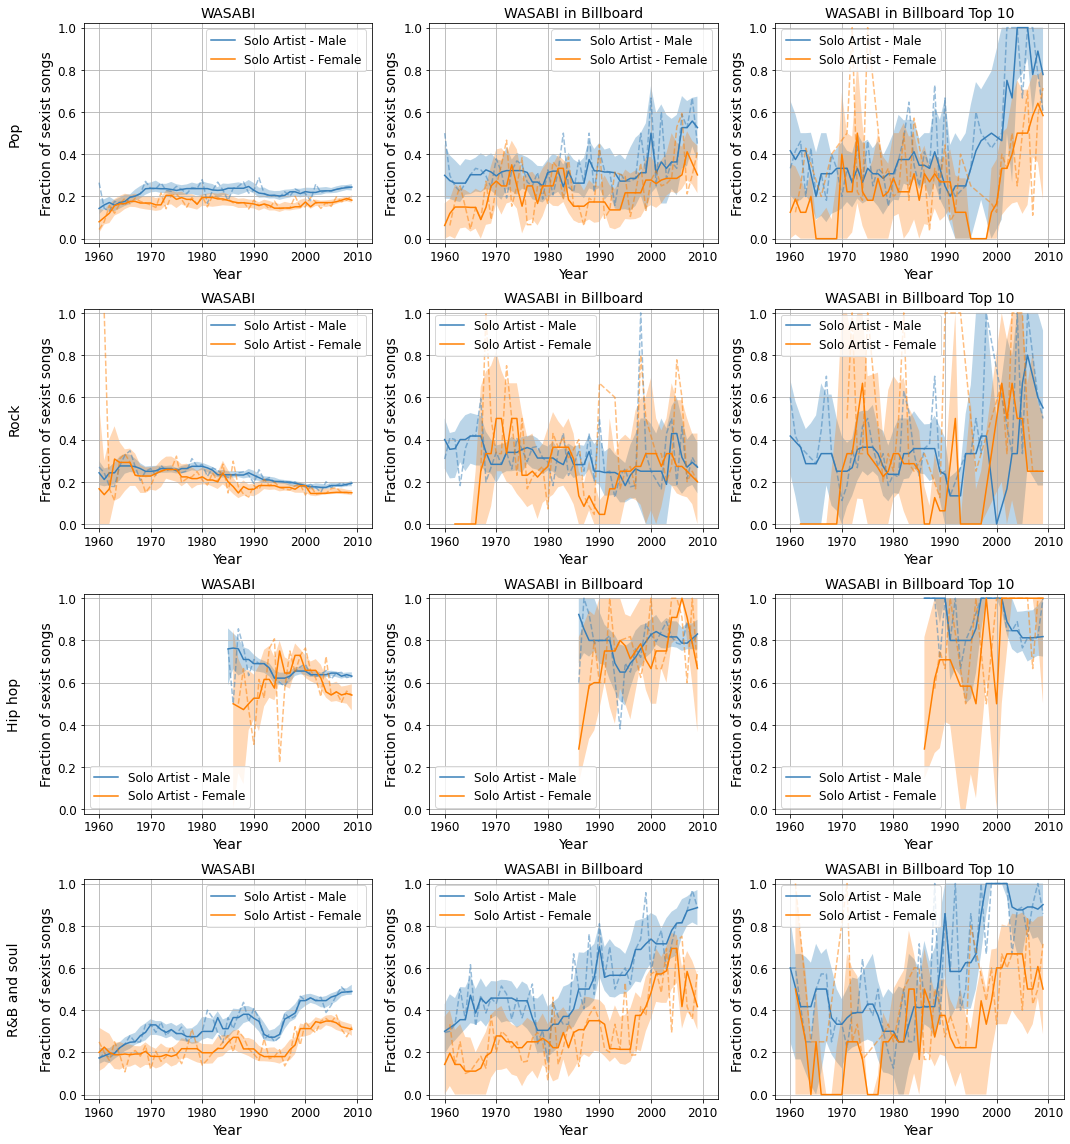

In [37]:
n_plots_shown = 0
genres_to_show = ['Pop', 'Rock', 'Hip hop', 'R&B and soul']

n_plots = (len(genres_to_show)) * 3

n_cols = 3
n_rows = np.ceil(n_plots // n_cols)

fig = plt.figure(figsize=(15,4*n_rows))


for ii, genre in enumerate(genres_to_show, 0):
    if genre in genres_to_skip:
        continue

    for jj, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard, song_lyrics_billboard_top10],
                                           ['WASABI', 'WASABI in Billboard', 'WASABI in Billboard Top 10']),
                                       1):
        
        if genre=='Hip hop':
            df = df[df.song_year_combined>=1985]

        plt.subplot(n_rows, n_cols, 3*ii+jj)
        for gender in ['Male', 'Female']:
            df_ = df[(df.artist_type=='Person')&
                     (df.genre_combined_reduced.apply(lambda gs: genre in gs))&
                        (df.artist_gender==gender)]
            frac_type_gender = df_.groupby('song_year_combined')['is_sexist']\
                                        .value_counts(1).loc[:, True].sort_index()

            line = get_line_with_median_smoothing(df_, iters=100, random_state=rng)

            l = plt.plot(line[:, 0], line[:, 1], label=f'Solo Artist - {gender}', color=categ2color[f'Person - {gender}'])
            plt.plot(frac_type_gender.index, frac_type_gender.values, alpha=0.5, color=l[0].get_color(), ls='dashed')
            #plt.fill_between(line[:, 0], line[:, 1]-line[:, 2], line[:, 1]+line[:, 3], alpha=0.3)
            plt.fill_between(line[:, 0], line[:, 2], line[:, 3], alpha=0.3)
        
        plt.xlabel('Year', fontsize=14)
        if jj==1:
            plt.ylabel(f'{genre}\n\nFraction of sexist songs', fontsize=14)
        else:
            plt.ylabel(f'Fraction of sexist songs', fontsize=14)
        plt.tick_params(labelsize=12)
        plt.title(df_name, fontsize=14)
        plt.grid()
        plt.legend(fontsize=12)
        plt.ylim(-0.02, 1.02)
        plt.xlim(1957, 2013)
        n_plots_shown += 1

plt.tight_layout()
#fig.savefig("frac_sexist_songs_wasabi_and_billboard_genre.pdf", dpi=500, format='pdf')  

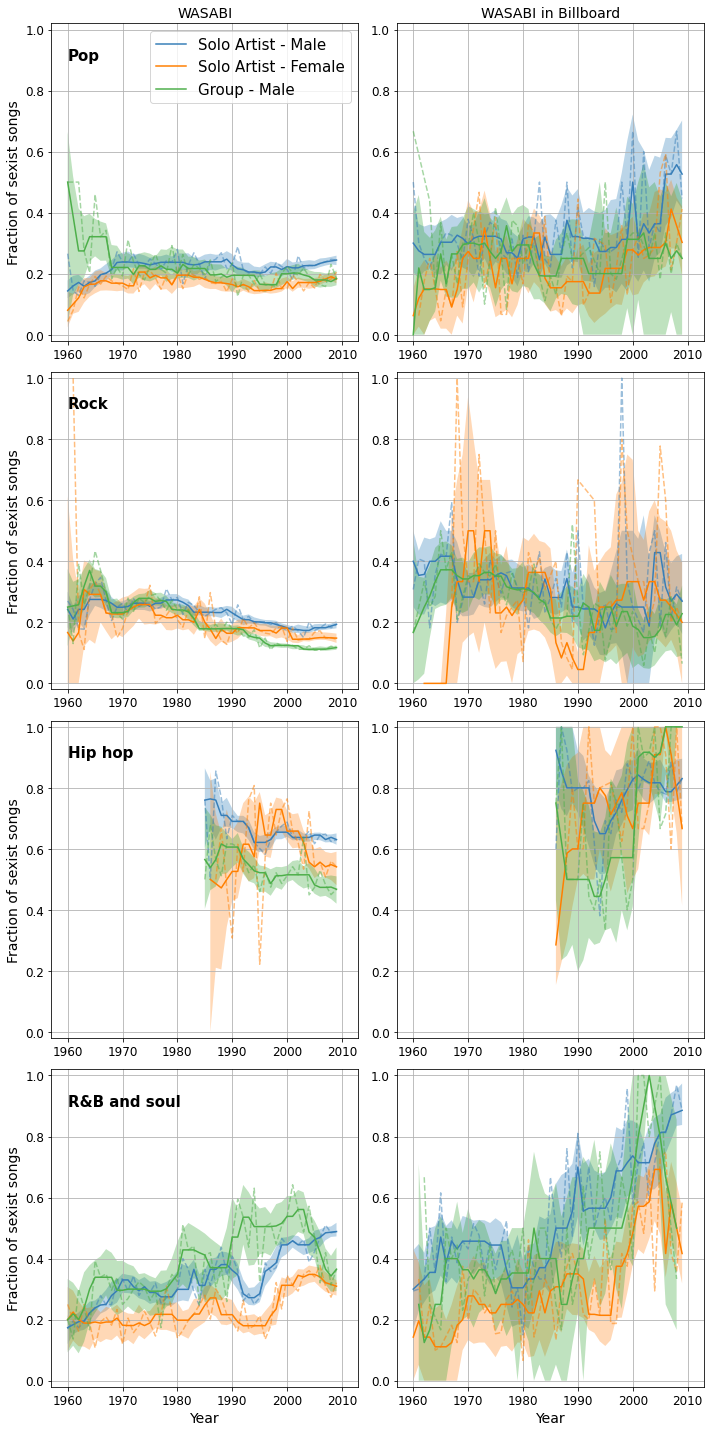

In [36]:
n_plots_shown = 0
genres_to_show = ['Pop', 'Rock', 'Hip hop', 'R&B and soul']

n_plots = (len(genres_to_show)) * 2

n_cols = 2
n_rows = np.ceil(n_plots // n_cols)

fig = plt.figure(figsize=(10,5*n_rows))


for ii, genre in enumerate(genres_to_show, 0):
    if genre in genres_to_skip:
        continue

    for jj, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard],
                                           ['WASABI', 'WASABI in Billboard']),
                                       1):
        
        if genre=='Hip hop':
            df = df[df.song_year_combined>=1985]

        plt.subplot(n_rows, n_cols, 2*ii+jj)
        for artist_type in ['Person', 'Group']:
            for gender in ['Male', 'Female']:
            
                if gender=='Female' and artist_type=='Group': continue

                df_ = df[(df.artist_type==artist_type)&
                        (df.genre_combined_reduced.apply(lambda gs: genre in gs))&
                            (df.artist_gender==gender)]
                frac_type_gender = df_.groupby('song_year_combined')['is_sexist']\
                                            .value_counts(1).loc[:, True].sort_index()

                line = get_line_with_median_smoothing(df_, iters=100, random_state=rng)

                artist_type_ = 'Solo Artist' if artist_type=='Person' else artist_type
                l = plt.plot(line[:, 0], line[:, 1], label=f'{artist_type_} - {gender}', color=categ2color[f'{artist_type} - {gender}'])
                plt.plot(frac_type_gender.index, frac_type_gender.values, alpha=0.5, color=l[0].get_color(), ls='dashed')
                #plt.fill_between(line[:, 0], line[:, 1]-line[:, 2], line[:, 1]+line[:, 3], alpha=0.3)
                plt.fill_between(line[:, 0], line[:, 2], line[:, 3], alpha=0.3)
        
        if ii==3:
            plt.xlabel('Year', fontsize=14)
        if jj==1:
            plt.ylabel(f'Fraction of sexist songs', fontsize=14)
        else:
            #plt.ylabel(f'Fraction of sexist songs', fontsize=14)
            pass

        plt.tick_params(labelsize=12)
        if genre=='Pop':
            plt.title(df_name, fontsize=14)

            if jj==1:
                plt.legend(fontsize=15)

        if jj==1:
            plt.text(1960, 0.9, genre, weight="bold", fontsize=15)

        plt.grid()
        
        plt.ylim(-0.02, 1.02)
        plt.xlim(1957, 2013)
        n_plots_shown += 1

plt.tight_layout()
fig.savefig("frac_sexist_songs_wasabi_and_billboard_genre.pdf", dpi=500, format='pdf')  

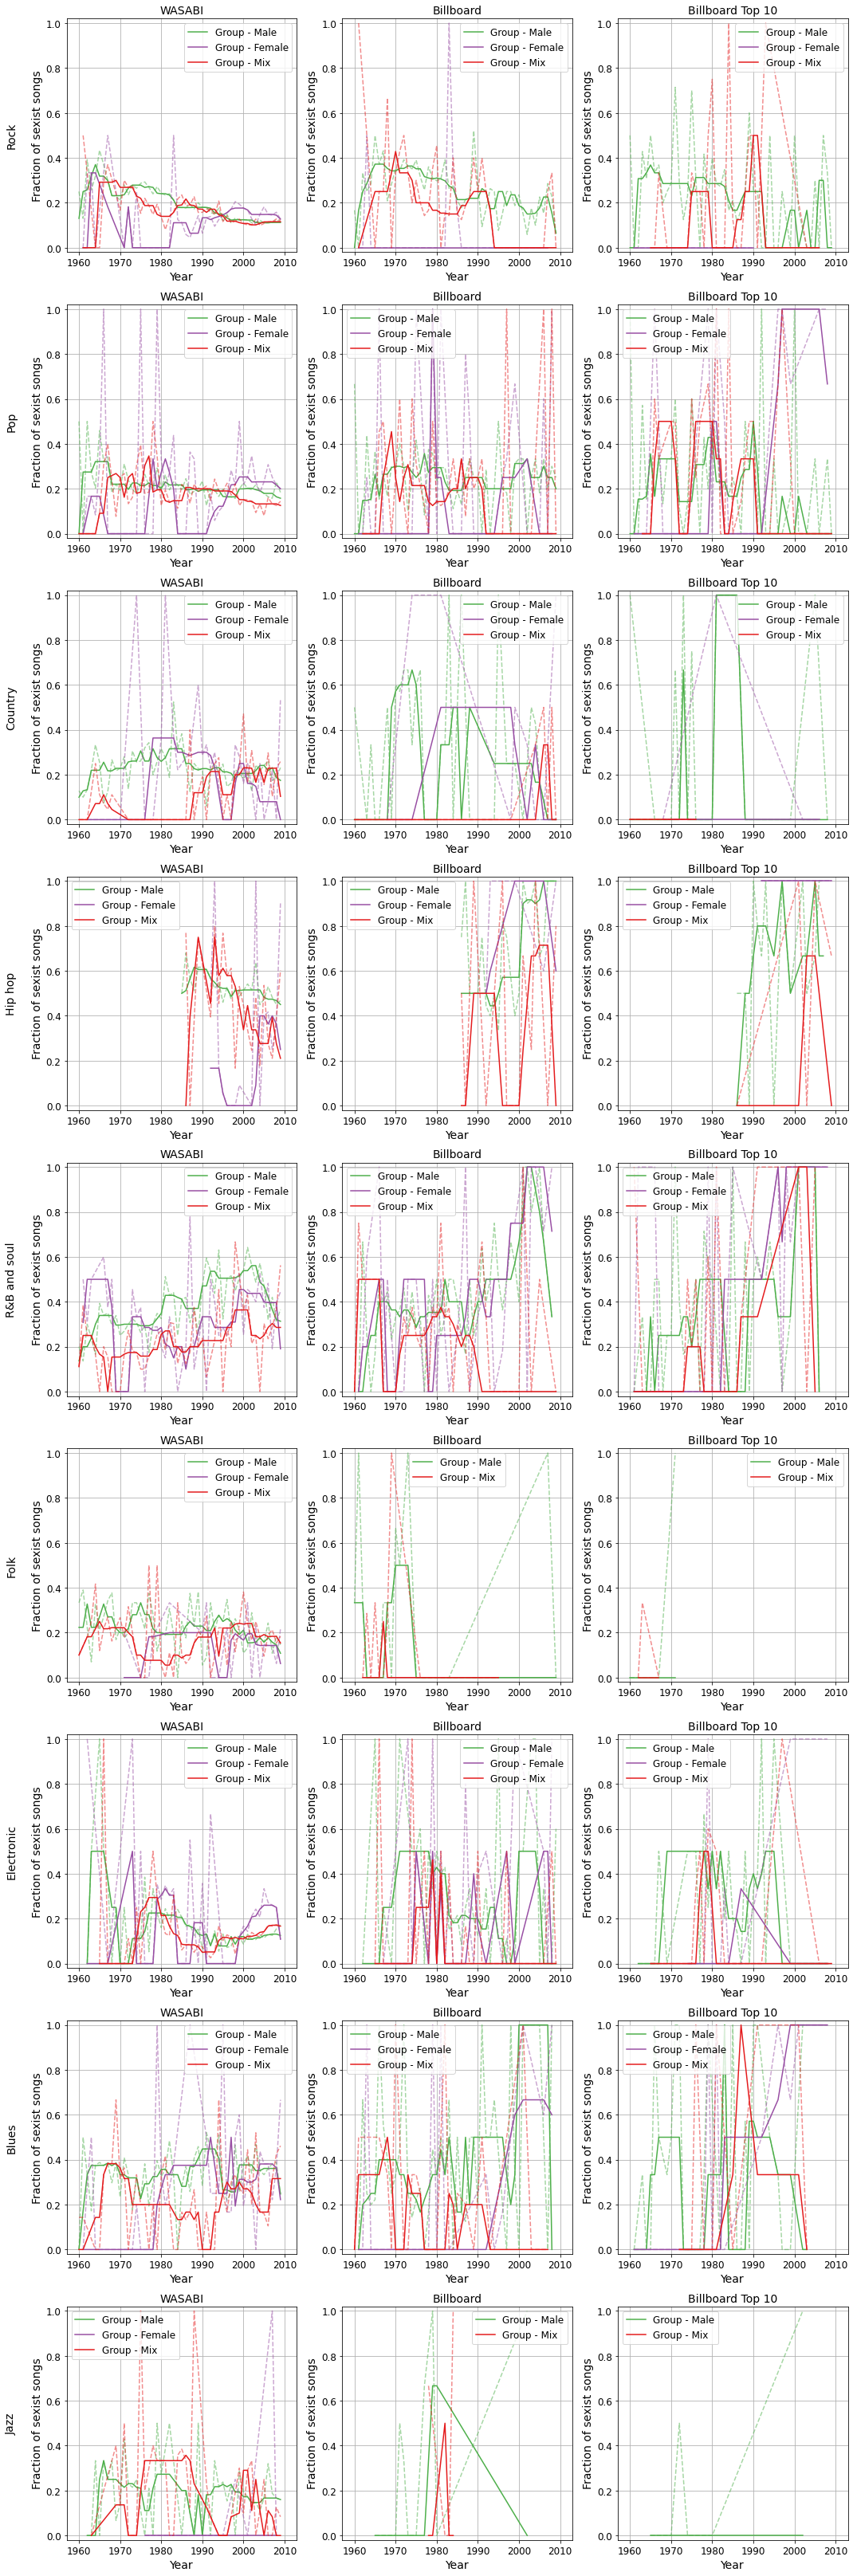

In [ ]:
n_plots_shown = 0
n_plots = (len(n_songs_for_genre.index) - len(genres_to_skip)) * 3

n_cols = 3
n_rows = np.ceil(n_plots // n_cols)

plt.figure(figsize=(15,5*n_rows))


for ii, genre in enumerate(n_songs_for_genre.index, 0):
    if genre in genres_to_skip:
        continue

    for jj, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard, song_lyrics_billboard_top10],
                                           ['WASABI', 'Billboard', 'Billboard Top 10']),
                                       1):
        
        if genre=='Hip hop':
            df = df[df.song_year_combined>=1985]

        plt.subplot(n_rows, n_cols, 3*ii+jj)
        for gender in ['Male', 'Female', 'Mix']:
            frac_type_gender = df[(df.artist_type=='Group')&
                                  (df.genre_combined_reduced.apply(lambda gs: genre in gs))&
                                (df.artist_gender==gender)]

            if frac_type_gender.shape[0]==0: continue
            frac_type_gender = frac_type_gender.groupby('song_year_combined')['is_sexist']\
                                                .value_counts(1)
            levels = [frac_type_gender.index.levels[0], [True, False]]
            new_index = pd.MultiIndex.from_product(levels, names=frac_type_gender.index.names)
            frac_type_gender = frac_type_gender.reindex(new_index, fill_value=0)

            frac_type_gender = frac_type_gender.loc[:, True].sort_index()
            plot_line_with_smoothing(frac_type_gender.index, frac_type_gender.values, label=f'Group - {gender}',
                                     color=categ2color[f'Group - {gender}'])
        
        plt.xlabel('Year', fontsize=14)
        if jj==1:
            plt.ylabel(f'{genre}\n\nFraction of sexist songs', fontsize=14)
        else:
            plt.ylabel(f'Fraction of sexist songs', fontsize=14)
        plt.tick_params(labelsize=12)
        plt.title(df_name, fontsize=14)
        plt.grid()
        plt.legend(fontsize=12)
        plt.ylim(-0.02, 1.02)
        plt.xlim(1957, 2013)
        n_plots_shown += 1

plt.tight_layout()
    

### Are Hip hop and R&B and soul drivivng the increase of sexist songs?

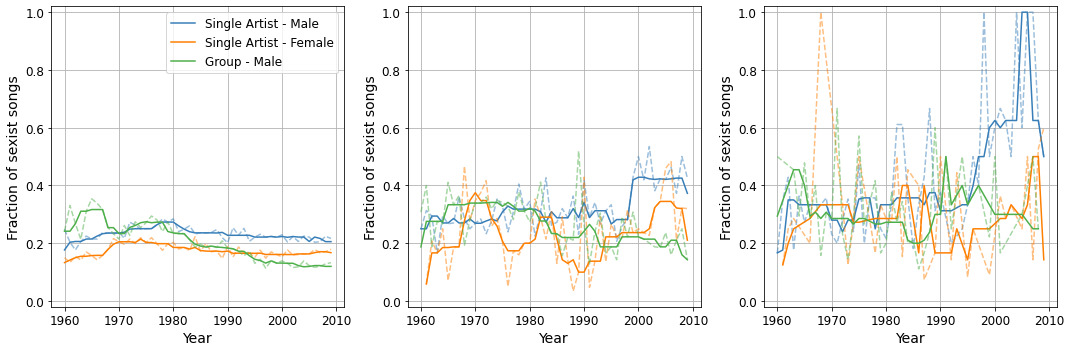

In [ ]:
#  plot fraction of sexist songs across time without rnb and hip hop

plt.figure(figsize=(15,5))


for jj, (df, df_name) in enumerate(zip([song_lyrics, song_lyrics_billboard, song_lyrics_billboard_top10],
                                        ['WASABI', 'WASABI in Billboard', 'WASABI in Billboard Top 10']),
                                    1):
    plt.subplot(1,3,3*0+jj)
    for ii, artist_type in enumerate(['Person', 'Group'], 0):
        
        for gender in ['Male', 'Female', 'Mix']:
            if gender=='Mix' and artist_type=='Person': continue
            #if artist_type=='Group' and gender in ['Female', 'Mix'] and df_name in ['WASABI in Billboard', 'WASABI in Billboard Top 10']: continue
            if artist_type=='Group' and gender in ['Female', 'Mix']: continue

            # remove hip hop and r&b
            frac_type_gender = df[(df.artist_type==artist_type)&
                                (df.artist_gender==gender)&
                                (df.genre_combined_reduced.apply(lambda gs: 'Hip hop' not in gs and "R&B and soul" not in gs))
                                ].groupby('song_year_combined')['is_sexist']\
                                        .value_counts(1).loc[:, True].sort_index()

            artist_type_ = 'Single Artist' if artist_type=='Person' else artist_type
            gender_ = 'Mixed' if gender=='Mix' else gender
            plot_line_with_smoothing(frac_type_gender.index, frac_type_gender.values, label=f'{artist_type_} - {gender_}',
                                     color=categ2color[f"{artist_type} - {gender}"])
        
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Fraction of sexist songs', fontsize=14)
    plt.tick_params(labelsize=12)
    if ii==0:
        plt.title(df_name, fontsize=14)
    plt.grid()
    plt.ylim(-0.02, 1.02)
    if jj==1:
        plt.legend(fontsize=12)
        
plt.tight_layout()
    